# Inpainting of satellite Images

The project is about image inpainting, that consists in filling deteriorated, or missing parts of a picture to reconstruct a complete image.

The dataset taken into consideration is the tensorflow EuroSAT dataset based on Sentinel-2 satellite images, in the the rgb version. This consists of 27000 images, at resolution 64x64.

A portion of the image is randomly masked according to the procedure described below. You goal is it reconstruct the full image.



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

Downloading and prepring the dayaset can take a few minutes.

In [2]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

In [3]:
ds_train = ds_train['train']

In [4]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [5]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

The generator gives you your training data.
We create a mask by drawing random vertical lines at different angles, and with variable variable width. The portion of the image retained is that under the mask.

In [6]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64 ,64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

Let us visually inspect our data. In the first row we plot the masked image, and in the laater row the original to be reconstructed.

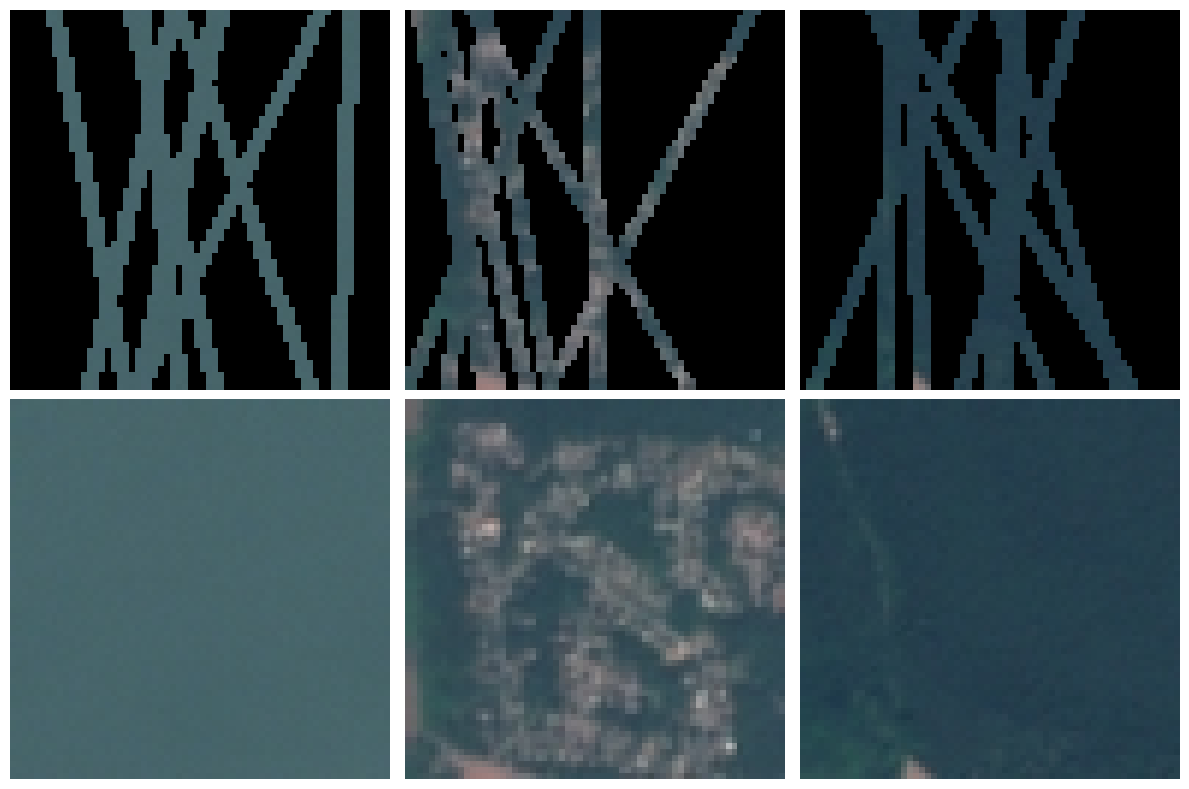

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

## What to deliver, and evaluation metric

The network must be written in tensorflow/keras. As usual, you are supposed to deliver a single notebook, containing a full trace of the training of your network. You may use any loss function for training.

You are supposed to **evaluate the quality of your reconstruction using mse.**

Compute it over 10000 images generated from the test set.

Repeat the previous computation 10 times, and provide the mean value and the standard deviation.

## Good work!


In [8]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Conv2DTranspose,
    concatenate,
    Lambda
)
from keras import callbacks

In [10]:
from keras.models import Model
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [11]:
from tensorflow.keras.optimizers import Adam

## Gianluca Di Mauro
## 0001078580
## Email: gianluca.dimauro@studio.unibo.it


## Model definition and choices explanation

After several attempts, the best architecture that I came up with is a classical UNET.
The attempts I made include a GAN, which was obtaining promising results (around 0.88 accuracy on test set), but with training time and complexity not making it worth, with a single epoch lasting up to 4 minute, with a minum need of training the network for 15-20 epochs; a WNET, where basically I thought of using two UNETs instead of one, because the results the single UNET produces look like blurry images, so I thought of training a second one, but with focus on making sharper images from prediction of the first net. The results were slightly better, but the training became much slower and complex.

This network architecture is designed following a classical UNET structure, with a focus on hierarchical feature extraction through a deep encoder-decoder framework.

The network begins with a series of convolutional layers in the encoder part, gradually reducing spatial dimensions while increasing feature depth. This hierarchy allows the network to capture increasingly abstract representations of the input image. 

Pooling layers are interspersed throughout the encoder, strategically placed to downsample feature maps, reducing computational complexity while retaining important spatial information

In the decoder section, upsampling operations are employed to gradually reconstruct the spatial dimensions of the encoded features. These upsampling layers help recover spatial details lost during the encoding process, ultimately producing a high-resolution output.

Skip connections, as usually in a UNET, are incorporated to facilitate information flow between corresponding encoder and decoder layers. These connections help alleviate the vanishing gradient problem and promote feature reuse, enabling the network to reconstruct fine details accurately.

Each decoder block consists of convolutional layers followed by ReLU activations, similar to the encoder. These layers refine the reconstructed features, gradually bringing them closer to the ground truth image.

Therefore, a Lambda layer is applied at the very end. It takes two inputs: the masked image given in input to the network and the output of the last layer of the network (note that this last layer uses a **sigmoid** activation function to squash the values within the range [0,1]). So, the Lambda layer is in charge of replacing the masked input region with the new generated values in the respective position. 

In [9]:
def get_model(input_shape):

    x = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64,  kernel_size=1, padding="same", activation="relu")(x)
    conv1 = Conv2D(64, kernel_size=3, padding="same", activation="relu")(conv1)
    conv1 = Conv2D(64, kernel_size=5, padding="same", activation="relu")(conv1)
    p1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128, kernel_size=3, padding="same", activation="relu")(p1)
    conv2 = Conv2D(128,kernel_size=4, padding="same", activation="relu")(conv2)
    conv2 = Conv2D(128,kernel_size=5, padding="same", activation="relu")(conv2)
    p2 = MaxPooling2D(2)(conv2)

    conv3 = Conv2D(256, kernel_size=3, padding="same", activation="relu")(p2)
    conv3 = Conv2D(256, kernel_size=4, padding="same", activation="relu")(conv3)
    conv3 = Conv2D(256, kernel_size=5, padding="same", activation="relu")(conv3)
    p3 = MaxPooling2D(2)(conv3)

    conv4 = Conv2D(512, kernel_size=3, padding="same", activation="relu")(p3)
    conv4 = Conv2D(512, kernel_size=4, padding="same", activation="relu")(conv4)
    conv4 = Conv2D(512, kernel_size=5, padding="same", activation="relu")(conv4)
    p4 = MaxPooling2D(2)(conv4)

    # Bottleneck
    Bottleneck = Conv2D(1024, kernel_size=3, padding="same", activation="relu")(p4)
    Bottleneck = Conv2D(1024, kernel_size=3, padding="same", activation="relu")(Bottleneck)

    # Decoder
    up1 = Conv2DTranspose(512, kernel_size=2, strides=(2, 2), padding="same", activation="relu")(Bottleneck)
    skip1 = concatenate([conv4, up1], axis=-1)
    conv5 = Conv2D(512, kernel_size=3, padding="same", activation="relu")(skip1)
    conv5= Conv2D(512, kernel_size=4, padding="same", activation="relu")(conv5)
    conv5= Conv2D(512, kernel_size=5, padding="same", activation="relu")(conv5)

    up2 = Conv2DTranspose(256, kernel_size=2, strides=(2, 2), padding="same", activation="relu")(conv5)
    skip2 = concatenate([conv3, up2], axis=-1)
    conv6= Conv2D(256, kernel_size=3, padding="same", activation="relu")(skip2)
    conv6 = Conv2D(256, kernel_size=4, padding="same", activation="relu")(conv6)
    conv6 = Conv2D(256, kernel_size=5, padding="same", activation="relu")(conv6)

    up3 = Conv2DTranspose(128, kernel_size=2, strides=(2, 2), padding="same", activation="relu")(conv6)
    skip3 = concatenate([conv2,up3], axis=-1)
    conv7 = Conv2D(128, kernel_size=3, padding="same", activation="relu")(skip3)
    conv7 = Conv2D(128, kernel_size=4, padding="same", activation="relu")(conv7)
    conv7 = Conv2D(128, kernel_size=5, padding="same", activation="relu")(conv7)

    up4 = Conv2DTranspose(64, kernel_size=2, strides=(2, 2), padding="same", activation="relu")(conv7)
    skip3 = concatenate([conv1,up4], axis=-1)
    conv8 = Conv2D(64, kernel_size=3, padding="same", activation="relu")(skip3)
    conv8 = Conv2D(64, kernel_size=4, padding="same", activation="relu")(conv8)
    conv8 = Conv2D(64, kernel_size=5, padding="same", activation="relu")(conv8)

    # Output layer
    output = Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")(conv8)
    replacement_layer = Lambda(lambda x: tf.where(tf.equal(x[0], 0), x[1], x[0]))([x, output])

    return Model(x,output)

In [12]:
input_shape = (64, 64, 3)

In [13]:
model = get_model(input_shape)

## Loss Function and Learning Rate choice
The loss function chosen is the Mean absolute Error (MAE). The reason behind this choice, aside from empirical evidence that I encountered during the implementation of the model, is that doesn't amplify outliers, in contrast with the more used MSE, which I tested and achied good results, but slightly worse. I also tested Binary Cross Entropy, which showed similar results to MSE. Worthy of mention some tests using Huber loss, which shows high speed in converging in fewer epochs, but then it drastically slows down.
A wide range of learning rates has been tested, reaching an optimal value of 1e-3, which can be further lowered by one of the two callbacks utilized during training, as explained in the next section.

In [14]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mean_absolute_error',
    metrics=["accuracy"]
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           256       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 64)           102464    ['conv2d_1[0][0]']            
                                                                                              

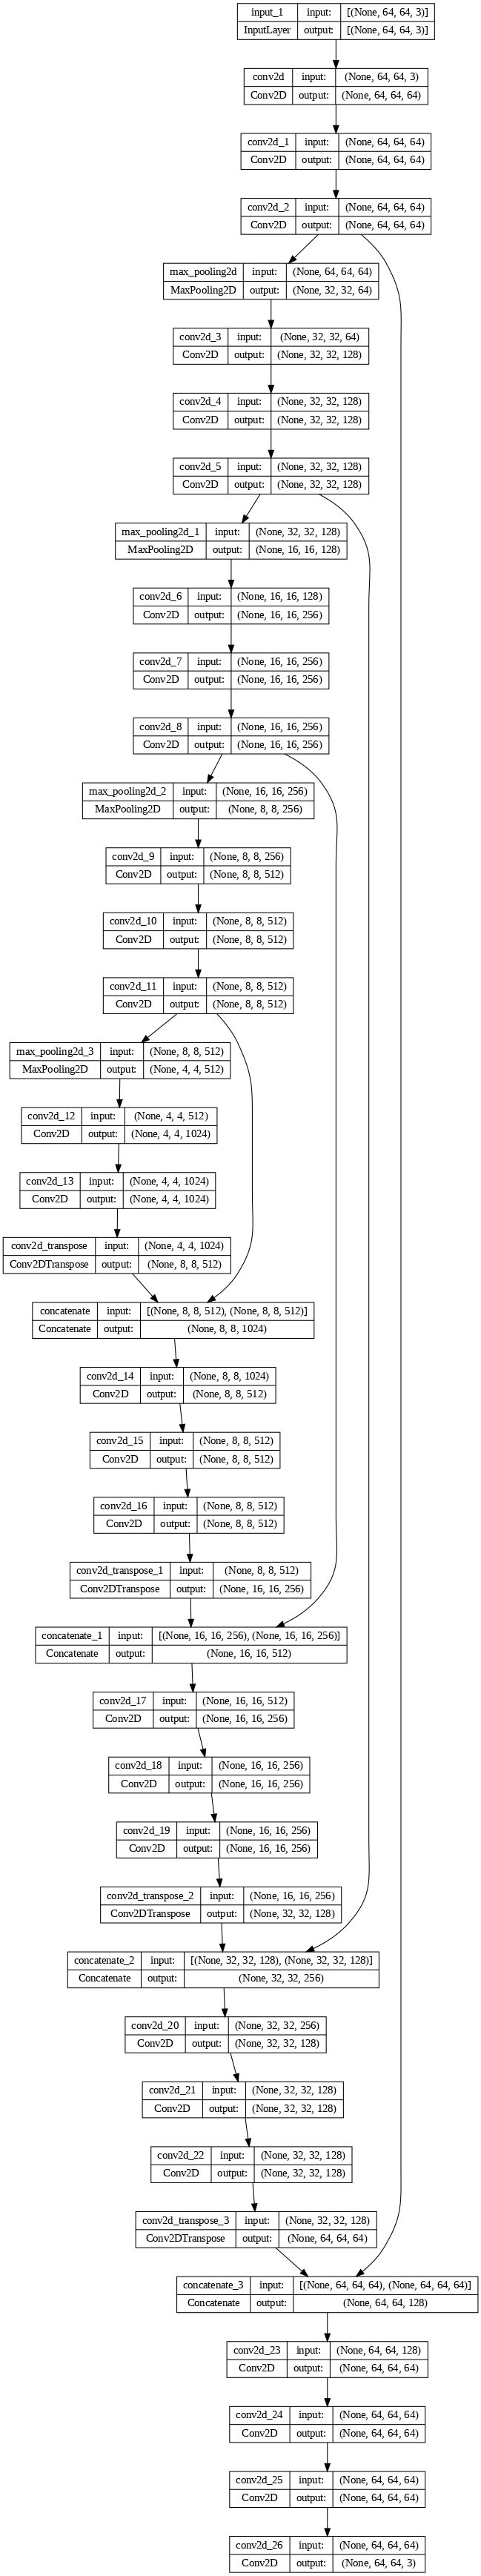

In [16]:
plot_model(model, show_shapes=True, dpi=76)

## Training

For the training two callbacks functions have been used. "EarlyStopping", which automatically detects when the chosen metric stops improving after n epochs, stopping the training and restoring the best weights found during training. And "ReduceLROnPlateu", which reduces the learning rate when the chosen metric has stopped improving.


In [17]:
stop_training = callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=15, restore_best_weights=True)
reduce_learning_rate = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=0.000001)

For the training, having tested different configurations, I found that using 2500 images per epochs was optimal. As validation set I used the test set, just to monitor the performance during training. The training has been set for 100 epochs, but the callbacks function will intervene and stop the training after roughly 30 epochs.

In [18]:
history = model.fit(x=train_generator,validation_data=test_generator, validation_steps=len(test_dataset_batched), epochs=100, steps_per_epoch=len(train_dataset_batched), verbose=1, shuffle=True,callbacks=[reduce_learning_rate, stop_training])

Epoch 1/100
2500/2500 [==============================] - 157s 54ms/step - loss: 0.0390 - accuracy: 0.7988 - val_loss: 0.0293 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 2/100
2500/2500 [==============================] - 159s 64ms/step - loss: 0.0285 - accuracy: 0.8792 - val_loss: 0.0271 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 3/100
2500/2500 [==============================] - 198s 79ms/step - loss: 0.0269 - accuracy: 0.8892 - val_loss: 0.0253 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 4/100
2500/2500 [==============================] - 136s 54ms/step - loss: 0.0259 - accuracy: 0.8952 - val_loss: 0.0248 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 5/100
2500/2500 [==============================] - 133s 53ms/step - loss: 0.0251 - accuracy: 0.8986 - val_loss: 0.0243 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 6/100
2500/2500 [==============================] - 142s 57ms/step - loss: 0.0248 - accuracy: 0.9017 - val_loss: 0.0250 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 7/100
2500/2500 [===========

In [19]:
def display_history(history):
    mse_training = history.history["loss"]
    acc_training = history.history["accuracy"]

    mse_val = history.history["val_loss"]
    acc_val = history.history["val_accuracy"]

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title("Loss during training")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title("Accuracy during training")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"])
    plt.show()

# Loss Analysis

As we can see from the two graphs below, both the loss and the accuracy initially converge after about 7-8 epochs, then from the 10th on the improvements are smaller

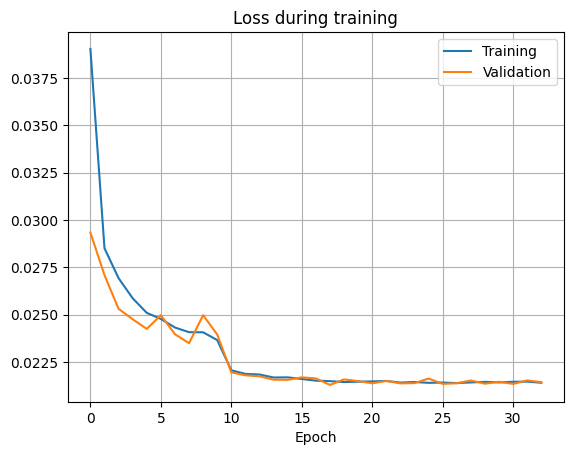

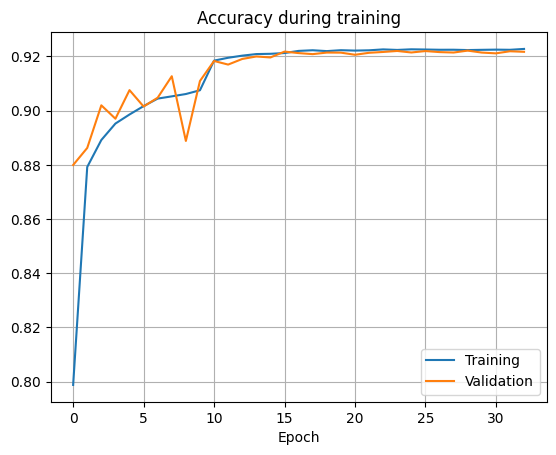

In [20]:
display_history(history)

# Prediction Example

In [21]:
a,b = next(test_generator)
predictions = model.predict(a,verbose=0)

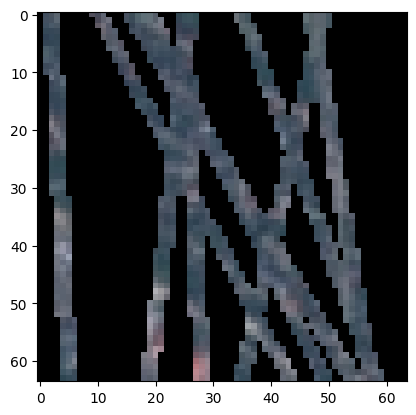

In [22]:
plt.imshow(a[1])
plt.show()

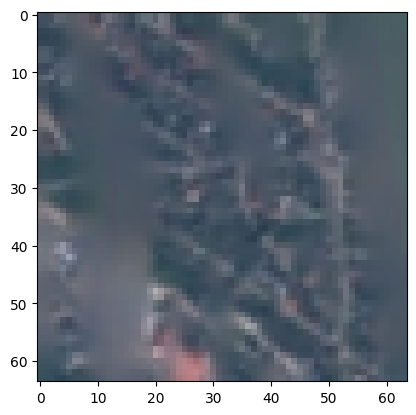

In [23]:
plt.imshow(predictions[1])
plt.show()

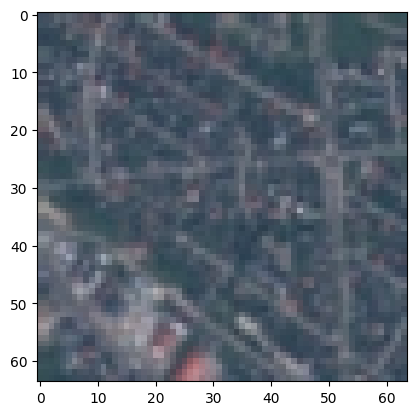

In [24]:
plt.imshow(b[1])
plt.show()

In [25]:
from keras import backend as K
# calculate the MSE between the predictions and ground truth
mse = K.mean(K.square(b - predictions))
# evaluate the model
print('Mean Squared Error:', K.eval(mse))

Mean Squared Error: 0.0018143166600493458


As we can see both by eye and by MSE on the single image, the result obtained is quite good, also considering the large dimension of masks in the training set.

# Model Evalutation
Here we can see overall model performances calculating MSE over 10000 images, repeating the operation 10 times.

In [26]:
# Initialize lists to store MSE values
iterations=10
num_images= 10000
batch_size = 8
mse_values = np.zeros(iterations)

# Repeat the computation 10 times
for i in range(iterations):
    total_mse = 0

    # Iterate over 10000 images
    for _ in range(num_images// batch_size):

        batch_mse = 0.0
        # Generate batch of 8 images from the test set
        batch, real_images = next(test_generator)

        # Get predictions from the model
        predictions = model.predict(batch, verbose=0)
        for j in range(batch_size):
        # Calculate MSE for the batch
              batch_mse += np.mean(np.square(predictions[j] - real_images[j]))

        # Accumulate MSE
        total_mse += batch_mse / batch_size
    mse_values[i] = total_mse / (num_images // batch_size)
    # Compute mean MSE for this iteration

mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

print("Mean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_dev_mse)


Mean MSE: 0.0024645101833180184
Standard Deviation of MSE: 2.143788029828799e-05


## Saving weights

In [27]:
model.save('weights')

In [28]:
!zip -r weights.zip weights

updating: weights/ (stored 0%)
updating: weights/fingerprint.pb (stored 0%)
updating: weights/assets/ (stored 0%)
updating: weights/saved_model.pb (deflated 90%)
updating: weights/variables/ (stored 0%)
updating: weights/variables/variables.index (deflated 74%)
updating: weights/variables/variables.data-00000-of-00001 (deflated 54%)
updating: weights/keras_metadata.pb (deflated 95%)
